In [1]:
from IPython.display import display, HTML
from matplotlib.pyplot import figure
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import r2_score

from keras import optimizers
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

Using TensorFlow backend.


#### Reading Files

In [0]:
files_names = []
for filename in glob.glob("datos/precios/*"):
    files_names.append(filename)

files_names.sort()
files_names[0:5]

#### Reading Data

In [0]:
final_price = pd.read_excel(files_names[0],skiprows = 3)
for i in range(1,len(files_names)):    
    count = 0 
    while(True): 
        price_i = pd.read_excel(files_names[i],skiprows = count).iloc[:,0:25]  
        if price_i.columns[0] == 'Fecha':
            break
        elif count >= 15:
            break
        else:
            count+=1
    final_price = pd.concat([final_price,price_i],ignore_index=True,axis=0) 

In [0]:
for i in range(final_price.shape[0]):
    if type(final_price.iloc[i,0]) != str:
        print(final_price.iloc[i,0])
        print(type(final_price.iloc[i,0]))
        break

1996-02-01 00:00:00
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [0]:
final_price["Fecha"] = pd.to_datetime(final_price["Fecha"])
final_price = final_price.sort_values(by=['Fecha'])
serie = pd.concat([final_price["Fecha"],final_price.mean(axis=1)],axis=1)
figure(num=None, figsize=(25,5), dpi=200, facecolor='w', edgecolor='k')
plt.plot(serie["Fecha"], serie.iloc[:,1],'k-.')
plt.show()

In [0]:
serie = serie.dropna() 
serie.isnull().sum()
serie = serie.reset_index(drop=True)
serie.columns = ["fecha","price"]

#### Feature Scaling

In [0]:
sc = MinMaxScaler(feature_range = (0, 1))
d = sc.fit_transform(serie["price"].values.reshape(-1,1)).reshape(-1,)

### Model without transforms

In [0]:
days = 24*7

In [0]:
tf.enable_eager_execution()

In [0]:
class Model(object):
    def __init__(self, L):        
        # Inicio mi vector de pesos
        self.w = tf.Variable([0.0] * (L))

    def __call__(self, x):
        # Añado bias a mi entrada y lo múltiplico por mis pesos para obtener el pronóstico
        x = tf.constant(np.array([1.0] + x, dtype=np.float32))
        y_pred = tf.reduce_sum(tf.multiply(self.w, x))
        return y_pred

    def fit(self, mu, x, y_desired):
        # multiplico por mis pesos
        y_pred = self(x)
        # saco mi error
        e = y_desired - y_pred
        # BIAS
        x = tf.constant(np.array([1.0] + x, dtype=np.float32))
        # gradient...
        self.w.assign_add(tf.scalar_mul(2 * mu * e, x))
        
        

#### Busqueda de retardos ideal


In [0]:
# N. retards
retards = [2,3,4,5,6,7,8,10]

def tuning_retards(retards,d):
    rresults = []
    for i in range(len(retards)):
        L = retards[i]
        model = Model(L)
        y_pred = np.empty(len(d))
        y_pred[:] = np.nan
        for t in range(L, len(d)):
            x = d[t-L:t]
            y_pred[t] = model(x)
            model.fit(mu=0.05, x=x, y_desired=d[t])
        rretards.append([d[-(days):],y_pred[-(days):]])
        
    return rretards

rretards = tuning_retards(retards,d)

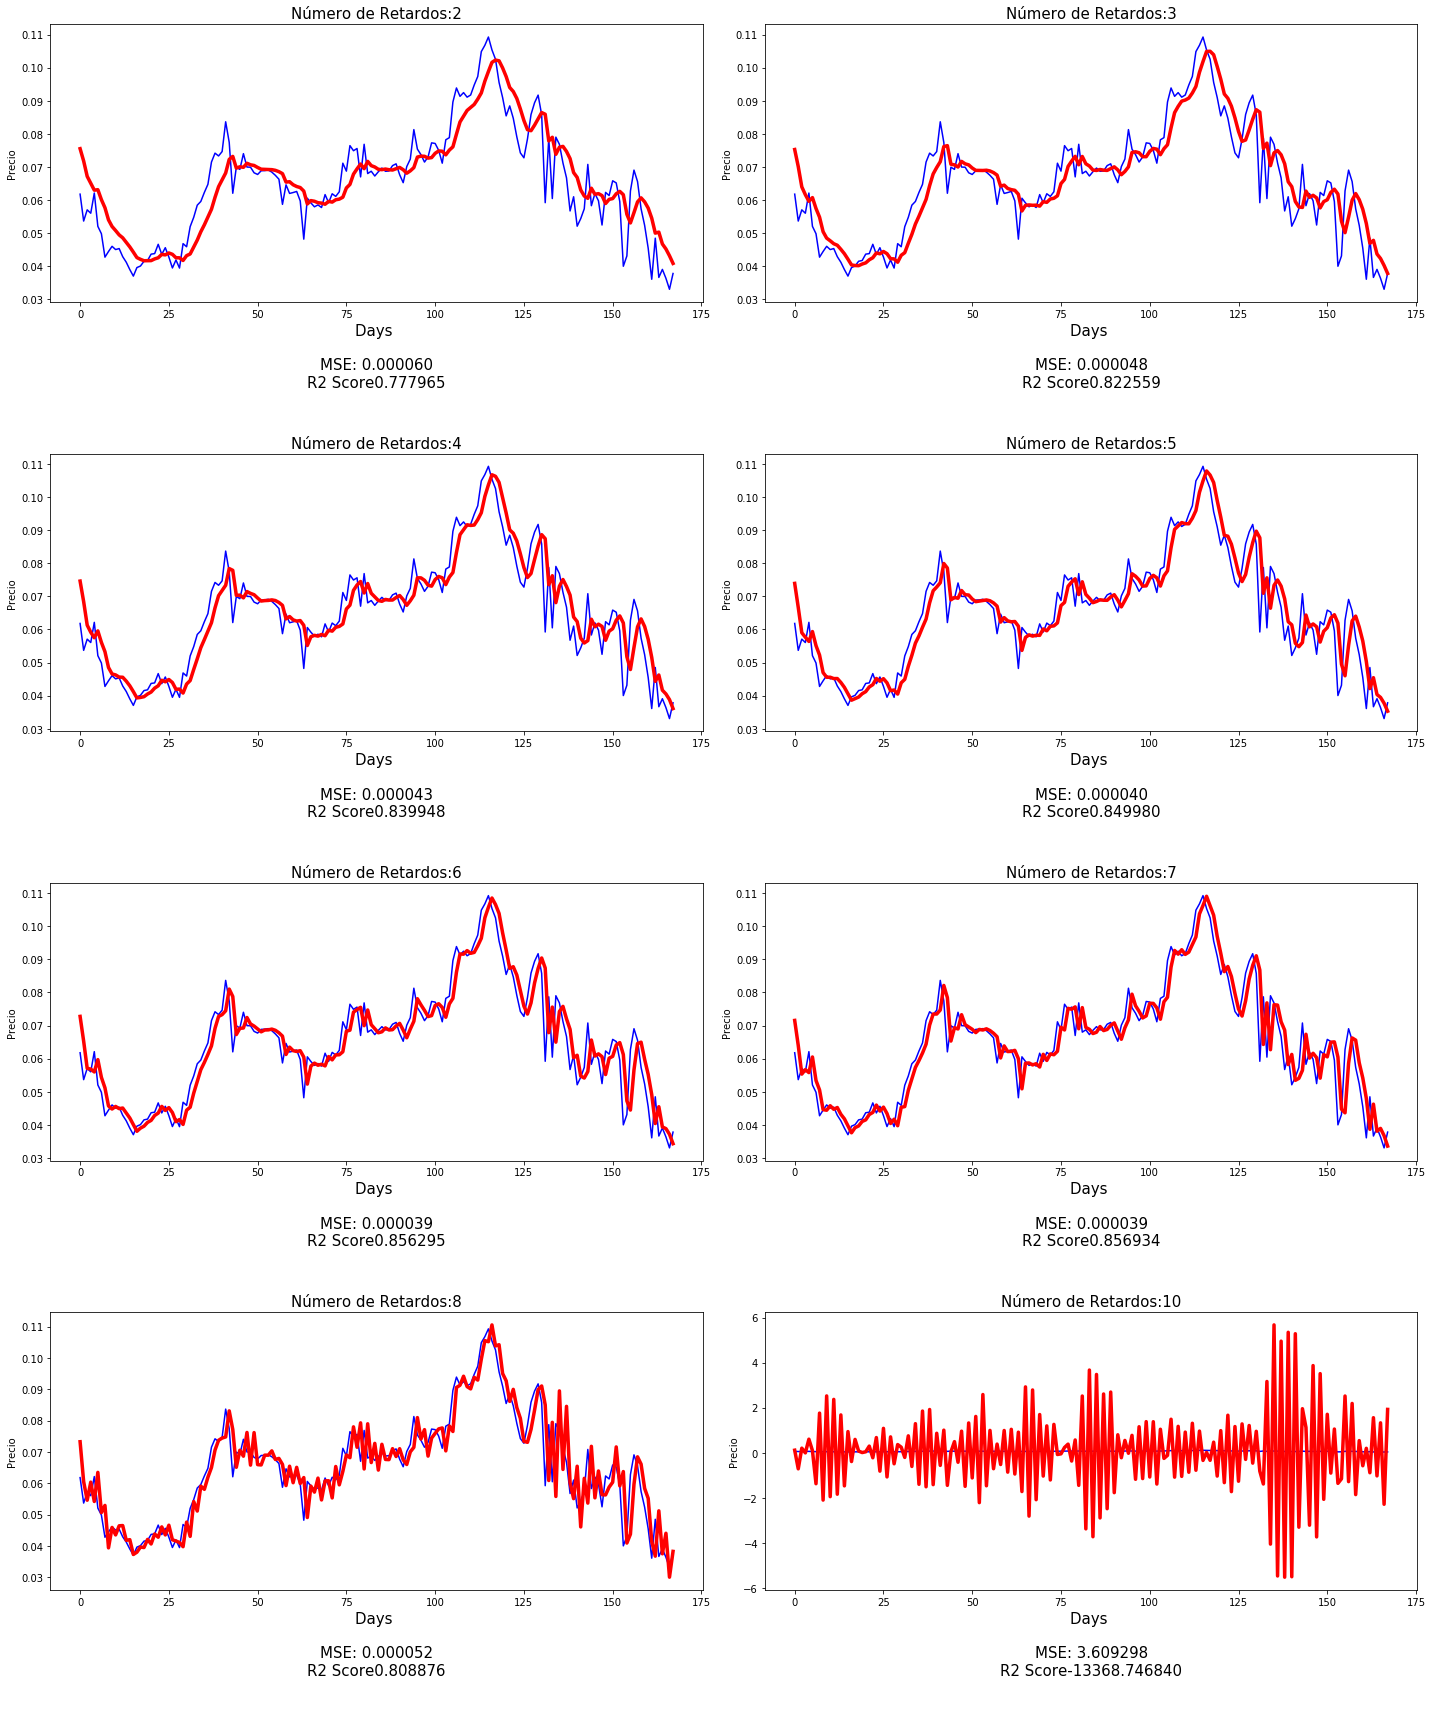

In [0]:
fig, axes = plt.subplots(nrows=4, ncols=2,figsize=(20,24))

count = 0
for fila in axes:
    for ax in fila:    
        ax.plot(resultado_retardos[count][0],color = 'green',label = 'Real')
        ax.plot(resultado_retardos[count][1],color = 'blue',label = 'Predicted',linewidth=3.5)
        ax.set_xlabel('Days \n \n'+                     
                      str('MSE: ' + '{:f}'.format(metrics.mean_squared_error(resultado_retardos[count][0],resultado_retardos[count][1])))+'\n'+
                      str('R2 Score' + '{:f}'.format(r2_score(resultado_retardos[count][0],resultado_retardos[count][1]))+'\n \n'),fontsize=12) 

        ax.set_ylabel('Precio')
        ax.set_title(str('Retards'+str(retardos[count])),fontsize=12)
        fig    
        plt.tight_layout()
        count+=1

### Calibración tasa de aprendizaje

In [0]:
lr = [0.1, 0.01,0.001,0.0001]
result_lr = []

for i in range(len(lr)): 
    L = 7
    model = Model(L)
    y_pred = np.empty(len(d))
    y_pred[:] = np.nan
    for t in range(L, len(d)):
        x = d[t-L:t]
        y_pred[t] = model(x)
        model.fit(mu=lr[i], x=x, y_desired=d[t])
    result_lr.append([d[-(days):],y_pred[-(days):]])

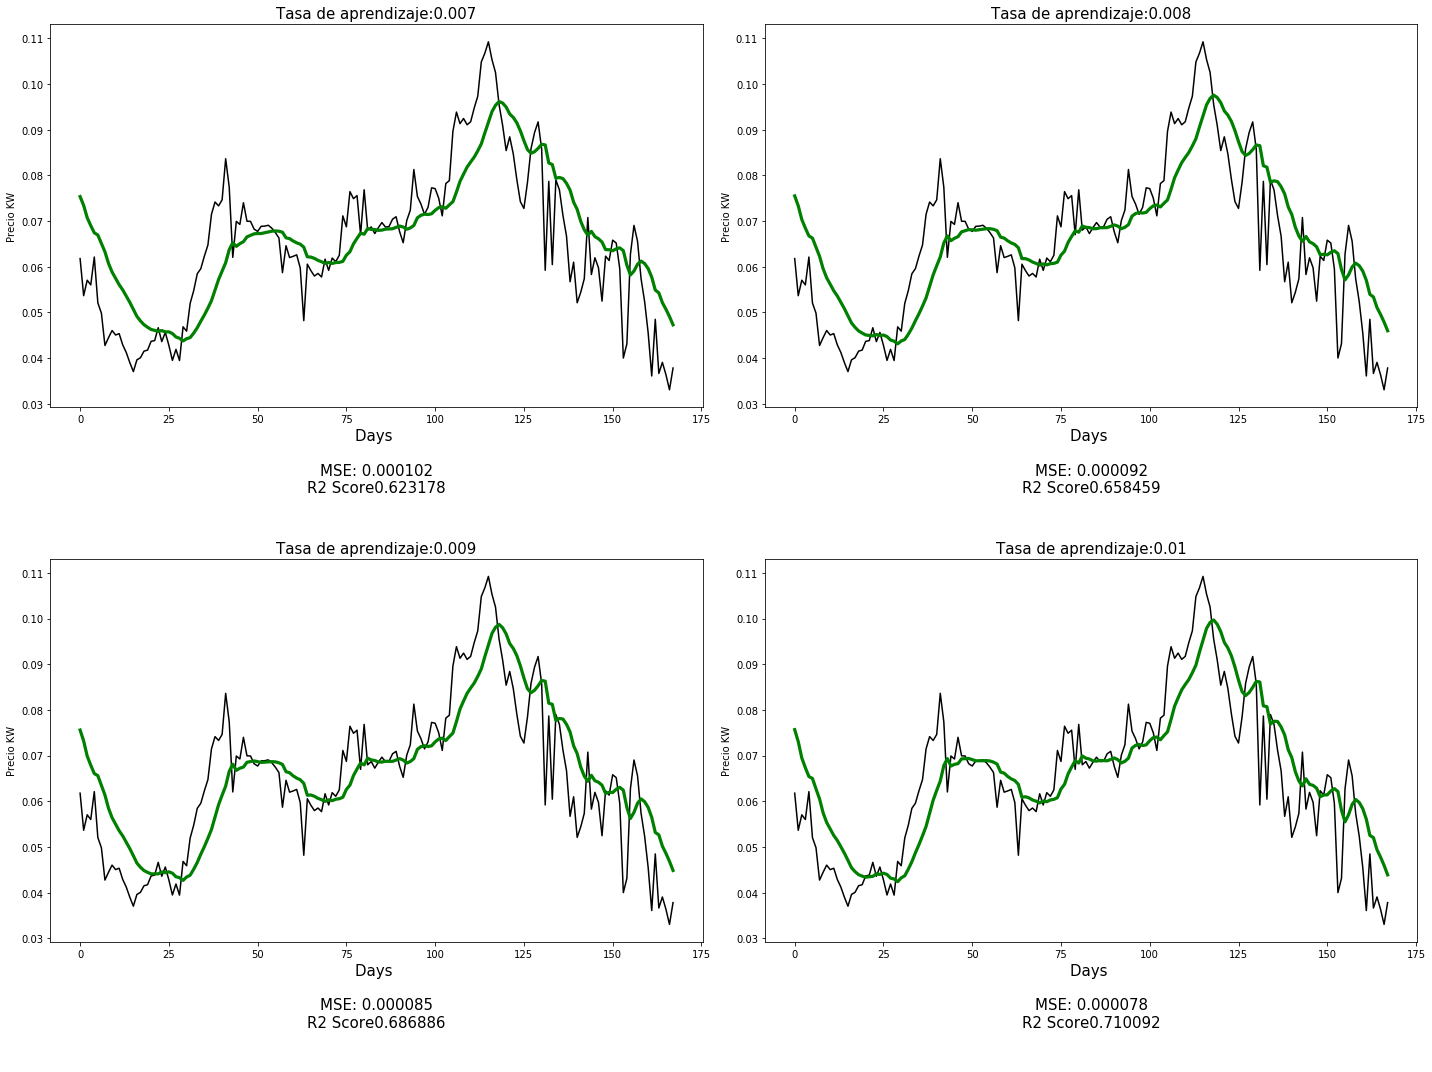

In [0]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(20,15))
count = 0
for fila in axes:   
    for ax in fila:     
        ax.plot(result_lr[count][0],color = 'black',label = 'Real')
        ax.plot(result_lr[count][1],color = 'green',label = 'Predicted',linewidth=3.2)
        ax.set_xlabel('Days \n \n'+                     
                      str('MSE: ' + '{:f}'.format(metrics.mean_squared_error(result_lr[count][0],result_lr[count][1])))+'\n'+
                      str('R2 Score' + '{:f}'.format(r2_score(result_lr[count][0],result_lr[count][1]))+'\n \n'),fontsize=12)                    
        ax.set_ylabel('price KW')
        ax.set_title(str('Learning Rate:'+str(lr[count])),fontsize=15)
        fig    
        plt.tight_layout()
        count+=1


#### Conociendo que rango es el adecuado se hace de nuevo un grid con valores cercanos a 0.01 para obtener un valor más preciso que un R2 de .67

In [0]:
lr = [0.007,0.008,0.009,0.01,0.02,0.03,0.04,0.05,0.06,0.07]
def tuning_lr(lr,d):
    result_lr = []
    for i in range(len(lr)):    
        L = 6
        model = Model(L)
        y_pred = np.empty(len(d))
        y_pred[:] = np.nan
        for t in range(L, len(d)):
            x = d[t-L:t]
            y_pred[t] = model(x)
            model.fit(mu=lr[i], x=x, y_desired=d[t])
        result_lr.append([d[-(days):],y_pred[-(days):]])   
    return result_lr

result_lr = tuning_lr(lr,d)

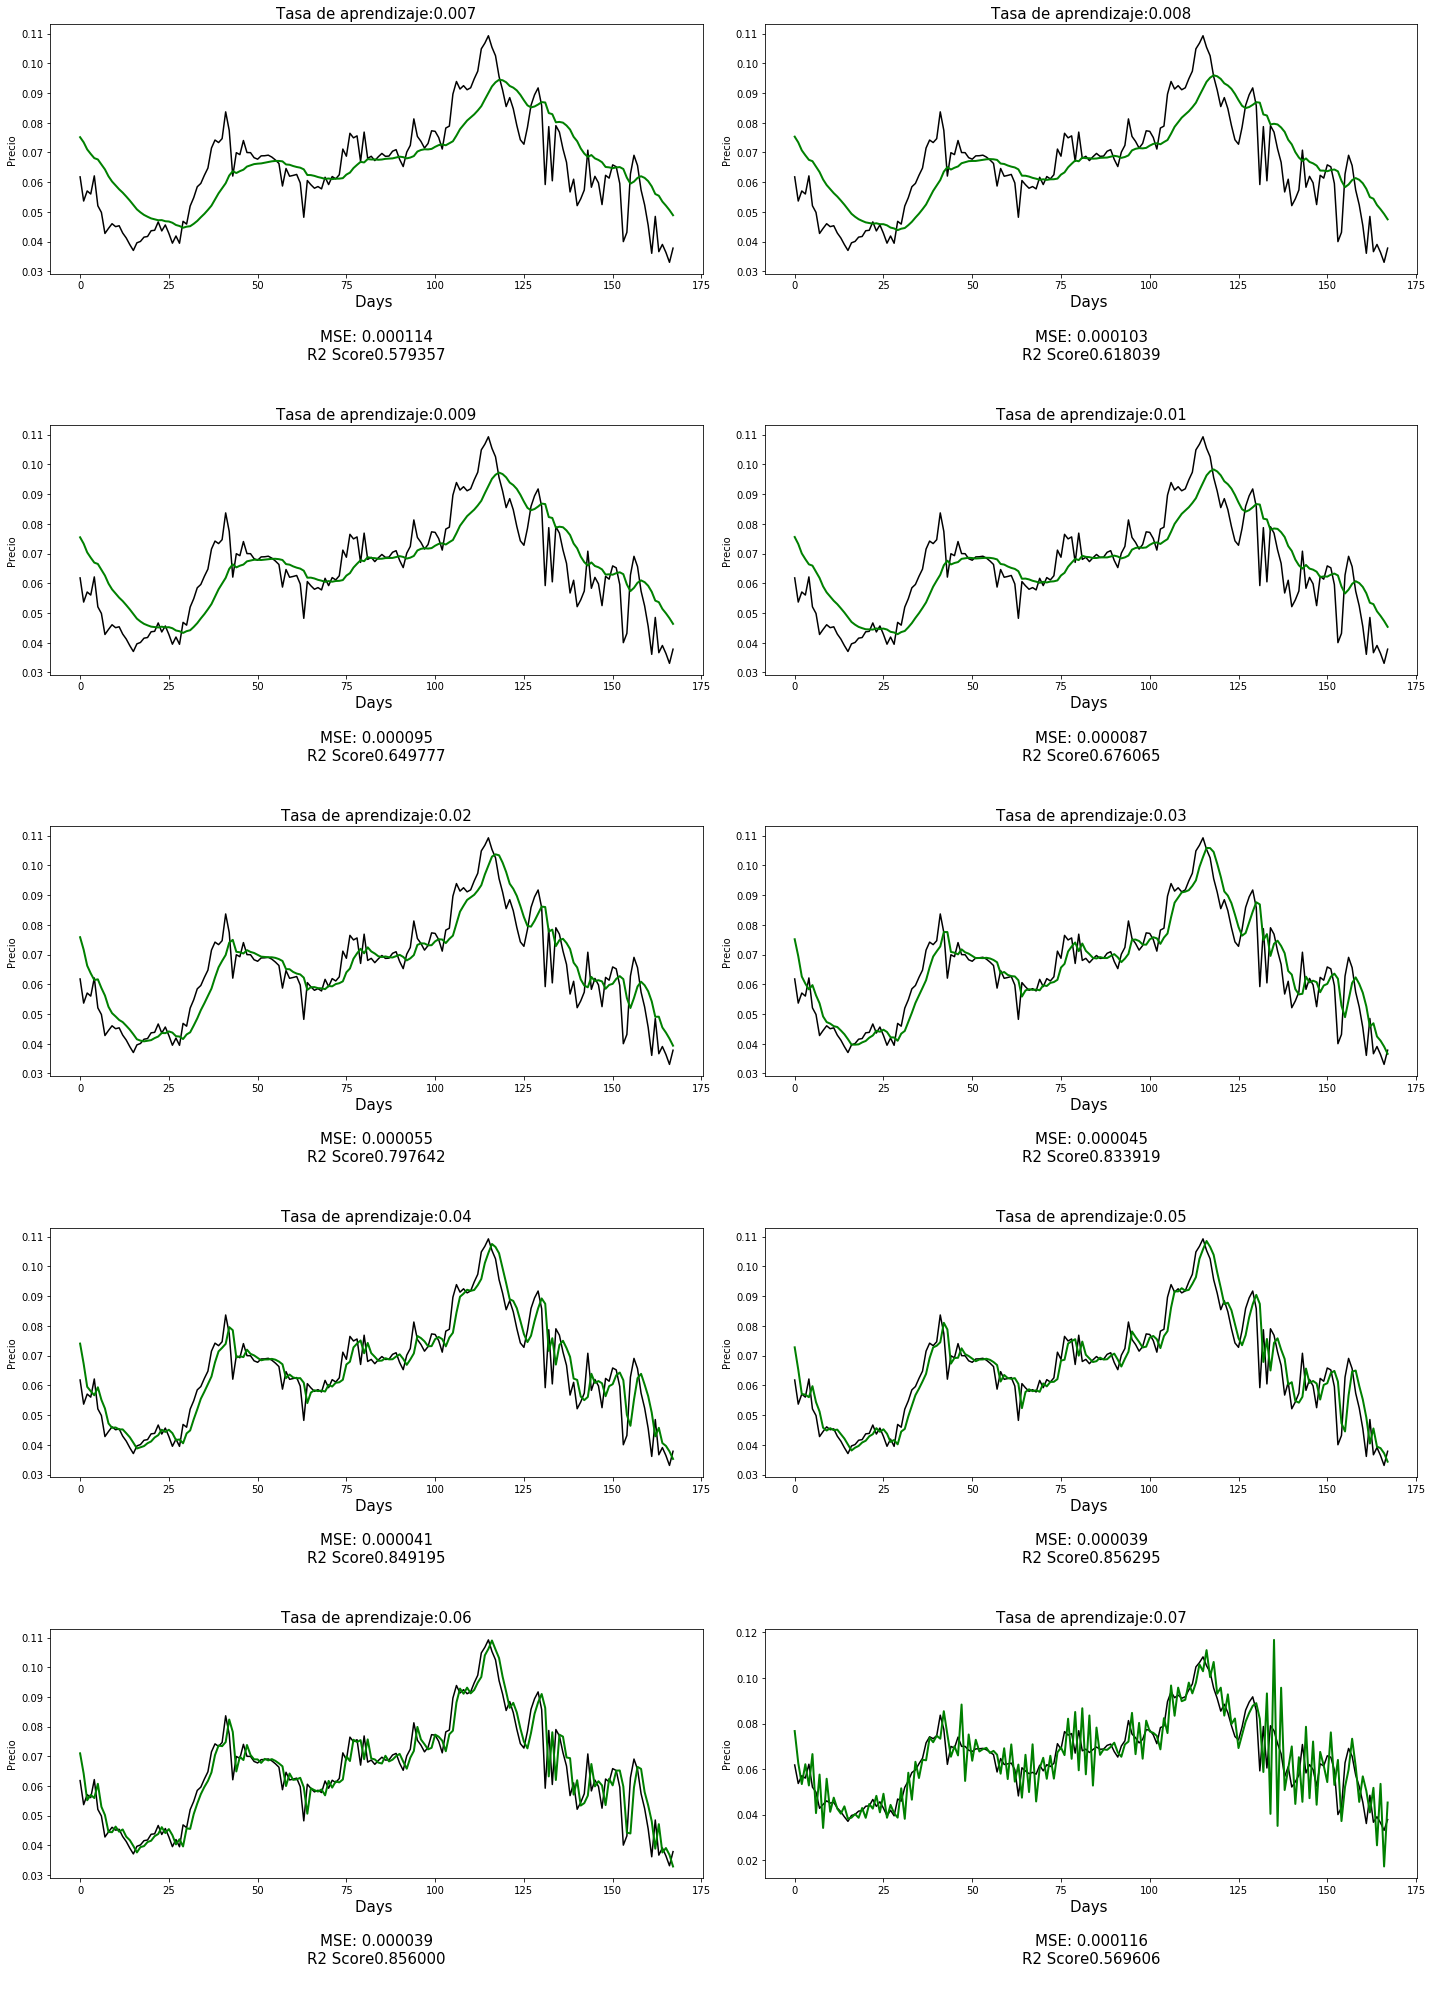

In [0]:
fig, axes = plt.subplots(nrows=5, ncols=2,figsize=(20,28))

count = 0
for fila in axes:   
    for ax in fila:
        ax.plot(result_lr[count][0],color = 'black',label = 'Real ')
        ax.plot(result_lr[count][1],color = 'green',label = 'Predicted',linewidth=2.0)
        ax.set_xlabel('Days \n \n'+                     
                      str('MSE: ' + '{:f}'.format(metrics.mean_squared_error(result_lr[count][0],result_lr[count][1])))+'\n'+
                      str('R2 Score' + '{:f}'.format(r2_score(result_lr[count][0],result_lr[count][1]))+'\n \n'),fontsize=12)                     
        ax.set_ylabel('Price')
        ax.set_title(str('Learning Rate:'+str(lr[count])),fontsize=12)
        fig    
        plt.tight_layout()
        count+=1


### La tasa de aprendizaje ideal para retardos que resulta mas adecuado (7) es igual 0,05


## Model without transforms but with the ideal parameters

In [0]:
def graficar_modelo(real,pred,nombre):
    #Graficar Resultados
    figure(figsize=(12,6))
    plt.plot(real, color = 'black', label = 'Real')
    plt.plot(pred, color = 'green', label = 'Predicho')
    plt.title(nombre)
    plt.xlabel('Horas/Día \n \n'+
              'R2: '+str(r2_score(real,pred))+'\n \n'
              'MSE: '+str(metrics.mean_squared_error(real, pred))
              )
    plt.ylabel('Price')
    plt.legend()
    return plt.show()

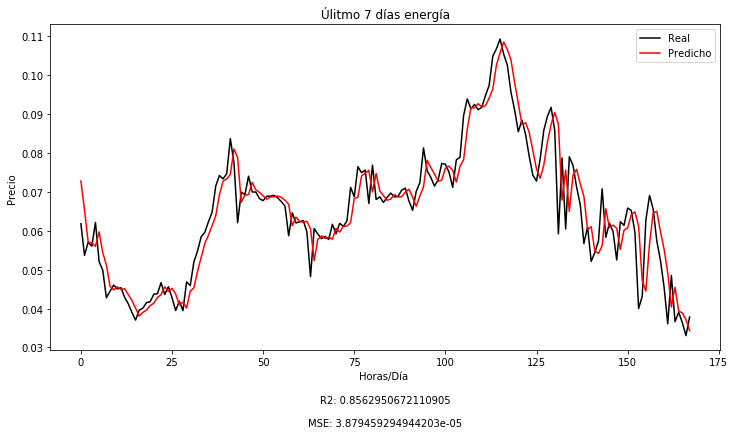

In [0]:
def adaline(L,lr,d):
    L = L
    model = Model(L)
    y_pred = np.empty(len(d))
    y_pred[:] = np.nan
    for t in range(L, len(d)):
        x = d[t-L:t]
        y_pred[t] = model(x)
        model.fit(mu=lr, x=x, y_desired=d[t])    
    return [d[-(days):],y_pred[-(days):]]    
modelo_sin_transf = adaline(6,0.05,d)
graficar_modelo(modelo_sin_transf[0],modelo_sin_transf[1],"Últimos 7 días energía")

### Select ideal transform

Comparacion del anterior modelo con diferentes transformaciones
 
 - *Raiz Cuadrada*
 - *Raíz Cúbica*
 - *Logaritmo Natural*

In [0]:
def evaluacion(resultados,parametros):    
    #Evaluacion del cambio de parametros
    metricas = []
    
    for i in range(len(resultados)):
        
        real,pred = resultados[i][0],resultados[i][1]
        
        r2 = r2_score(real,pred)
        mse = metrics.mean_squared_error(real, pred)
        
        metricas.append([r2,mse])
     
    df = pd.DataFrame(metricas,parametros)
    
    return df.sort_values(by=[0],ascending=False).iloc[0]

### Raíz Cuadrada

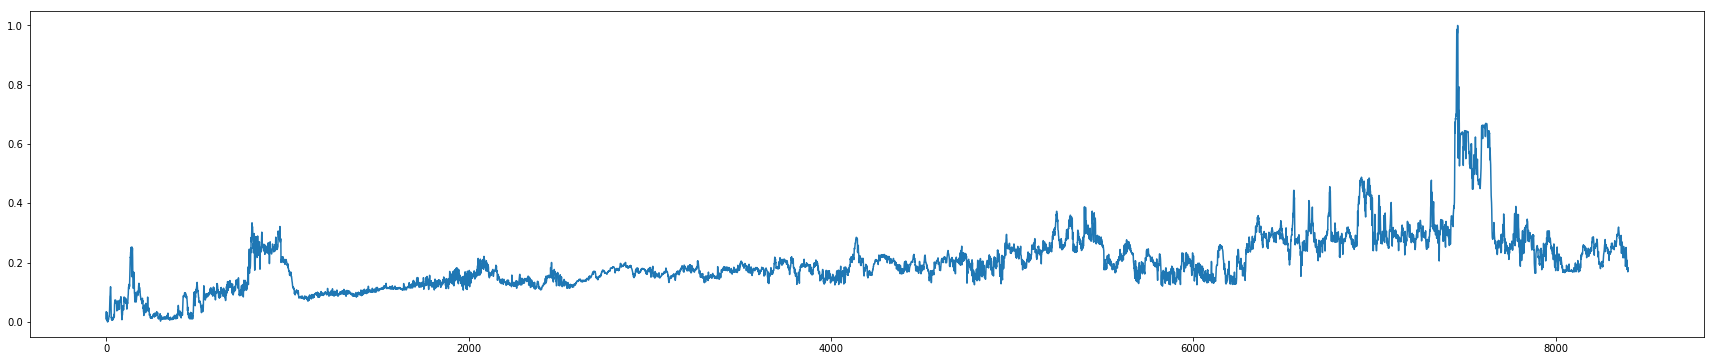

In [0]:
serie_sqrt = sc.fit_transform(serie["price"].apply(np.sqrt).values.reshape(-1,1)).reshape(-1,)
figure(figsize=(30,6))
plt.plot(serie_sqrt)

#### Tuninig Retardos

In [0]:
# evaluacion de la calibracion de retardos para raiz cuadrada 
resultado_retardos_sqrt = tuning_retardos(retardos,serie_sqrt)
# Mejor Parametro
mejor_retardo_sqrt = evaluacion(resultado_retardos_sqrt,retardos)
#Retardo 5 registros 
mejor_retardo_sqrt

#### Tuning LR

In [0]:
# evaluacion de la calibracion de LR para raiz cuadrada 
result_lr_sqrt = tuning_lr(lr,serie_sqrt)
# Mejor Parametro
mejor_lr_sqrt = evaluacion(result_lr_sqrt,lr)
# Learning Rate = 0.04
mejor_lr_sqrt
modelo_sqrt = adaline(5,0.04,serie_sqrt)
graficar_modelo(modelo_sqrt[0],modelo_sqrt[1],"SQRT Model")

### Raíz Cúbica

In [0]:
serie_cbrt = sc.fit_transform(np.array(serie["price"].apply(np.cbrt).values.reshape(-1,1))).reshape(-1,)
figure(figsize=(30,6))
plt.plot(serie_cbrt)

#### Tuninig Retardos

In [0]:
# evaluacion de la calibracion de retardos para raiz cúbica
resultado_retardos_cbrt = tuning_retardos(retardos,serie_cbrt)
resultado_retardos_cbrt = resultado_retardos_cbrt[0:6]
# Mejor parámetro
mejor_retardo_cbrt = evaluacion(resultado_retardos_cbrt,retardos[0:6])
# Retardo 5 registros 
mejor_retardo_sqrt

#### Tuning LR

In [0]:
# evaluacion de la calibracion de LR para de la raíz cúbica
result_lr_cbrt = tuning_lr(lr,serie_cbrt)
# Mejor parámetro
mejor_lr_cbrt = evaluacion(result_lr_cbrt,lr)
# LR 0.03
mejor_lr_cbrt
modelo_cbrt = adaline(5,0.03,serie_cbrt)
graficar_modelo(modelo_cbrt[0],modelo_cbrt[1],"Raiz Cubica")

### Log e (N)

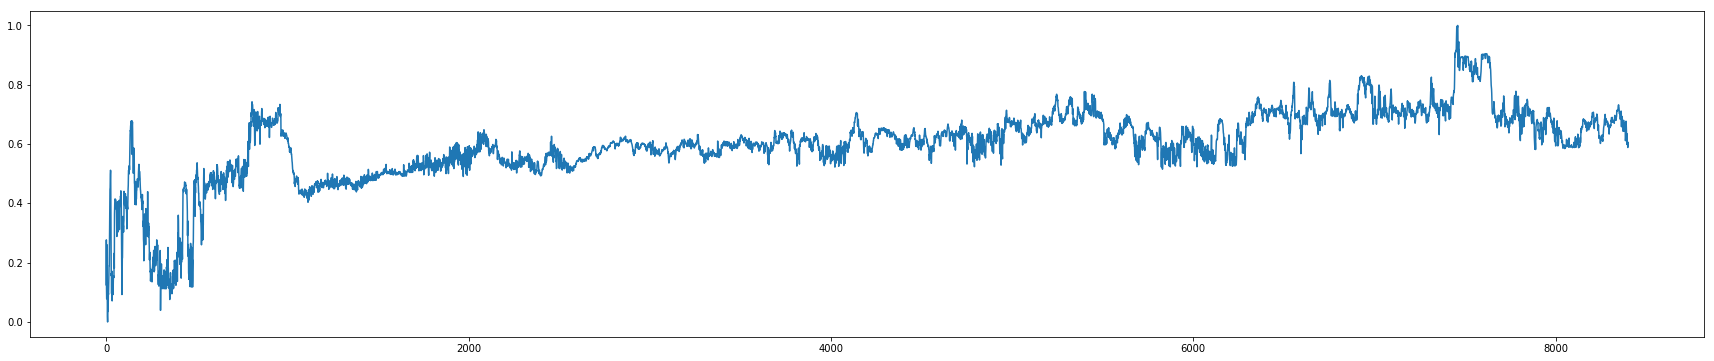

In [0]:
serie_log = sc.fit_transform(np.array(serie["price"].apply(np.log).values).reshape(-1,1)).reshape(-1,)
figure(figsize=(30,6))
plt.plot(serie_log)

#### Tuninig Retardos

In [0]:
# evaluacion de la calibracion de retardos de logaritmo natural
resultado_retardos_log = tuning_retardos(retardos,serie_log)
# Mejor parámetro
mejor_retardo_log = evaluacion(resultado_retardos_log[:-3],retardos[:-3])
# Retardo 2
mejor_retardo_log

#### Tuning LR

In [0]:
# evaluacion de la calibracion de LR de logaritmo natural
result_lr_log = tuning_lr(lr,serie_log)
# Mejor parámetro
mejor_lr_log = evaluacion(result_lr_log[:-2],lr[:-2])
# LR 0.04
mejor_lr_sqrt
modelo_log = adaline(2,0.04,serie_log)
graficar_modelo(modelo_log[0],modelo_log[1],"Log Natural")

**Resultados de los modelos con Adaline:**
    
    Sin transformación: 
        * MSE          0.8562      * R2       0.00005

    Raíz Cuadrada
         * MSE         0.8487      * R2       0.0001

    Raíz Cúbica
         * MSE         0.8453      * R2       0.0002

    Logaritmo Natural
         * MSE         0.8484      * R2       0.00015